<a href="https://colab.research.google.com/github/jhonysmf/MVP_Jhonys_Sprint_ED/blob/main/MVP_Jhonys_SprintED_documentado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP – Sprint Engenharia de Dados
##Aluno: Jhonys Machado de Freitas


##1.	Objetivos
O objetivo geral deste MVP é a busca, coleta, modelagem, carga e análise de  dados utilizando a plataforma Databricks Community Edition.
	Objetivos específicos:
Com a base de dados de pagamentos de bolsas e benefícios da FAPESP ( Fundação de Amparo à Pesquisa do Estado de São Paulo) responder as seguintes perguntas:
(Obs.: Por questões de praticidade bolsas e benefícios serão tratados como “bolsas” neste trabalho)
1. Quantas pessoas receberam bolsas no mês 06/2024?
2. Quantas instituições tem bolsistas?
3. Qual instituição contém mais bolsistas?
4. Qual instituição recebeu o maior valor de bolsa, somando todos os bolsistas da instituição.
5. Qual instituição contém o maior número de bolsistas que recebem bolsas de pós-doutorado no país?
6. Qual instituição contém o maior número de bolsistas que recebem bolsas de doutorado fora do país?
7. Qual foi o gasto total da FAPESP no mês de junho de 2024 com manutenção mensal de bolsas no país?


##2.	Base de dados
A base de dados utilizadas foi baixada no portal da transparência da FAPESP (https://fapesp.br/13197/bolsas-e-auxilios). Os dados selecionados foram os dados referentes a pagamento do mês de junho de 2024.
A tabela de dados foi baixada nos formatos .pdf, para consultas e o formato .csv para carga dos dados no Databricks.

Para a carga dos dados baixados do portal da FAPESP foi feito o upload do arquivo .csv (pagamento_bolsas_beneficiario_jun_2024-1.csv) no DBFS. Foi usado o pyspark e suas funções para a manipulação e ajuste dos dados importados. Os dados carregados possuíam colunas multilinhas no cabeçalho da

###Manipulação e ajuste da base de dados

Carga e qualidade dos dados.

Para a carga dos dados baixados do portal da FAPESP foi feito o upload do arquivo csv (pagamento_bolsas_beneficiario_jun_2024-1.csv) no DBFS.
Foi usado o pyspark e suas funções para a manipulação e ajuste dos dados importados.
Os dados carregados possuiam colunas multilinhas no cabecalho da tabela, por isso optou-se por não usar os títulos das colunas originais e defini-los novamente, baseados no arquivo original.

Logo que o DF foi carregando notou-se que a última coluna (Vigência FIM) estava com problema, portanto foi necessário corrigir o fim das entradas da coluna de “carriage return” (\r) para “vazio”, também nesse contexto foi necessário reformatar a data para essa coluna. Já para a parte da análise foi necessário alterar o formato numérico da coluna “PAGAMENTO_EM_06_2024” para o formato de leitura do Spark.

Obs. Certas colunas da tabela não foram utilizadas neste trabalho, mas não foram retiradas da tabela na intenção de dar continuidade com a prática e o treino utilizando este trabalho futuramente.


In [ ]:
!pip install --upgrade pip findspark
import findspark
findspark.init
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import expr
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

# Localização e tipo do arquivo
file_location = "/FileStore/shared_uploads/jhonysmf@gmail.com/pagamento_bolsas_beneficiario_jun_2024-1.csv"
file_type = "csv"

# CSV options
infer_schema = True
first_row_is_header = False
delimiter = ";"

# Carregando os dados
df = spark.read.format("csv") \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option("encoding", "ISO-8859-1") \
  .option("ESCAPE quote", '"') \
  .option("multiline", True) \
  .option("skipRows", 4) \
  .load(file_location)

# Definição dos nomes das colunas para o dataframe.
df = df.withColumnRenamed("_c0", "BENEFICIARIO") \
.withColumnRenamed("_c1", "INSTITUICAO") \
.withColumnRenamed("_c2", "TIPO_DE_BOLSA") \
.withColumnRenamed("_c3", "RUBRICA") \
.withColumnRenamed("_c4", "PAGAMENTO_EM_06_2024") \
.withColumnRenamed("_c5", "PARCELA_PAGA_EM_06_2024") \
.withColumnRenamed("_c6", "NIVEL_BOLSA") \
.withColumnRenamed("_c7", "TOTAL_DE_PARCELAS_CONCEDIDAS_NIVEL") \
.withColumnRenamed("_c8", "VIGENCIA_INICIO") \
.withColumnRenamed("_c9", "VIGENCIA_FIM")

# Correção das colunas que geraram problemas na análise do DF. (Vide texto de descrição anterior).
df = df.withColumn("VIGENCIA_FIM", F.regexp_replace(F.col("VIGENCIA_FIM"), "\r", "")) \
.withColumn("VIGENCIA_FIM", F.to_date("VIGENCIA_FIM", format="dd/MM/yy")) \
.withColumn("PAGAMENTO_EM_06_2024", F.regexp_replace(F.col("PAGAMENTO_EM_06_2024"), "\r", "")) \
.withColumn("PAGAMENTO_EM_06_2024", F.regexp_replace(F.col("PAGAMENTO_EM_06_2024"), "\\.", "")) \
.withColumn("PAGAMENTO_EM_06_2024", F.regexp_replace(F.col("PAGAMENTO_EM_06_2024"), ",", ".")) \
.withColumn("PAGAMENTO_EM_06_2024", F.col("PAGAMENTO_EM_06_2024").cast('decimal(15,2)'))

display(df.head(20))

BENEFICIARIO,INSTITUICAO,TIPO_DE_BOLSA,RUBRICA,PAGAMENTO_EM_06_2024,PARCELA_PAGA_EM_06_2024,NIVEL_BOLSA,TOTAL_DE_PARCELAS_CONCEDIDAS_NIVEL,VIGENCIA_INICIO,VIGENCIA_FIM
JULIAN CRISTIAN GONCALVES DA SILVA JUNIOR,FAC ENGENHARIA ILHA SOLTEIRA/UNESP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,IN,22132.290000000000000000,null,null,"5m, 5m",2024-07-15,2024-12-14
JULIAN CRISTIAN GONCALVES DA SILVA JUNIOR,FAC ENGENHARIA ILHA SOLTEIRA/UNESP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,TR,7078.010000000000000000,null,null,"5m, 5m",2024-07-15,2024-12-14
JULIAN CRISTIAN GONCALVES DA SILVA JUNIOR,FAC ENGENHARIA ILHA SOLTEIRA/UNESP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,SS,7108.500000000000000000,null,null,"5m, 5m",2024-07-15,2024-12-14
JULIAN CRISTIAN GONCALVES DA SILVA JUNIOR,FAC ENGENHARIA ILHA SOLTEIRA/UNESP,Bolsa no Pais - Regular - Pos-Doutorado,MM,9318.900000000000000000,10,null,24m,2023-09-01,2025-08-31
PAULO PIROZELLI ALMEIDA SILVA,ESC POLITECNICA/USP,Bolsa no Pais - Regular - Pos-Doutorado,MM,9318.900000000000000000,4,null,24m,2023-03-01,2025-02-28
VALDIR DE AQUINO LEMOS,ESC PAULISTA MEDICINA/UNIFESP,Bolsa no Pais - Regular - Pos-Doutorado,MM,9318.900000000000000000,9,null,24m,2022-10-01,2024-09-30
ANA FLAVIA BALOTARI BOTTA,FAC CIENCIAS TECNOLOGIA PRESIDENTE PRUDENTE/UNESP,Bolsa no Pais - Regular - Doutorado 1,MM,3805.800000000000000000,4,1,"12m ( nível 1), 25m ( nível 2)",2024-03-01,2027-03-31
MIRIANE LUCINDO ZUCOLOTO,FAC MEDICINA RIBEIRAO PRETO/USP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,MM,4659.450000000000000000,7,null,"12m, 12m",2023-12-01,2024-11-30
MIRIANE LUCINDO ZUCOLOTO,FAC MEDICINA RIBEIRAO PRETO/USP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,ME,20537.250000000000000000,7,null,"12m, 12m",2023-12-01,2024-11-30
MIRIANE LUCINDO ZUCOLOTO,FAC MEDICINA RIBEIRAO PRETO/USP,Bolsa no Exterior - Regular - Estagio de Pesquisa - PD,RB,2139.980000000000000000,null,null,"12m, 12m",2023-12-01,2024-11-30


##Informações sobre a Base de Dados inicial

In [ ]:
print(f"O arquivo possui: {df.count()} linhas")
print(f"O arquivo possui: {len(df.columns)} colunas")


O arquivo possui: 14639 linhas
O arquivo possui: 10 colunas


A tabela possui 14639 linhas, possuindo linhas com nomes de benefíciarios que se repetem, uma vez que eles tenham recebido tipos diferentes de bolsas no mês de Junho de 2024.

As 10 colunas da tabela se referem a: <br>
BENEFICIÁRIO : Nome da pessoa que recebeu a bolsa; <br>
INSTITUIÇÃO: Nome da instituição que o beneficiário atua; <br>
TIPO_DE_BOLSA: O tipo de bolsa que o beneficiário recebe (por questões de praticidade os tipos de bolsa não serão listados aqui por ser um grande número de bolsas diferentes, esses tipos de bolsas possíveis podem ser consultados em https://fapesp.br/bolsas); <br>
RUBRICA: A legenda de rubricas pode ser consultada em https://fapesp.br/13231/legenda-de-rubricas; <br>
PAGAMENTO_EM_06_2024: Valores das bolsas pagos no mês 06/2024; <br>
PARCELA_PAGA_EM_06_2024: O número da parcela do contrato da bolsa; <br>
NIVEL_BOLSA: O nível da bolsa para modalidades de bolsa com níveis; <br>
TOTAL_DE_PARCELAS_CONCEDIDAS_NIVEL: O número de parcelas já pagas ao respectivo beneficiário; <br>
VIGENCIA INICIO: A data da implantação da bolsa; <br>
VIGENCIA_FIM: A data do fim da bolsa. <br>
Caso necessário, maiores informações podem ser obtidas em https://fapesp.br/bolsas.

Obs. Os valores null na tabela se referem a informações que realmente não são necessárias ou não existem para serem especificadas, não comprometendo a análise dos dados.


## Perguntas iniciais.

Devido a limitações de uso da versão Community do Databricks, as análises foram realizadas na tabela tratada acima.

As perguntas do objetivo específico deste trabalho foram:

1. Quantas pessoas receberam bolsas no mês 06/2024?
2. Quantas instituições tem bolsistas?
3. Qual instituição contém mais bolsistas?
4. Qual instituição recebeu o maior valor de bolsa, somando todos os bolsistas da instituição.
5. Qual instituição contém o maior número de bolsistas que recebem bolsas de pós-doutorado no país?
6. Qual instituição contém o maior número de bolsistas que recebem bolsas de doutorado fora do país?
7. Qual foi o gasto total da FAPESP no mês de junho de 2024 com manutenção mensal de bolsas no país?

In [ ]:
df.createOrReplaceTempView("Bolsas")

#1. Quantas pessoas receberam bolsas no mês 06/2024?

pessoas = spark.sql("SELECT COUNT(DISTINCT BENEFICIARIO) FROM Bolsas")
display(pessoas)


count(DISTINCT BENEFICIARIO)
10129


Através da consulta SQL usando a função COUNT e DISTINCT pode-se ter o valor de quantas pessoas receberam bolsas, sem as repetições de mesmo Benefíciario recebendo difierentes tipos de bolsas. Portanto, a resposta para a pergunta 1 é 10129 pessoas.

In [ ]:
#2. Quantas instituições tem bolsistas?

instituicao = spark.sql("SELECT COUNT(DISTINCT INSTITUICAO) FROM Bolsas")
display(instituicao)


count(DISTINCT INSTITUICAO)
491


O numero de instituições que receberam algum tipo de bolsa em 06/2023 foi de 491.

In [ ]:
#3. Qual instituição contém mais bolsistas?

instituicao = spark.sql("SELECT COUNT(INSTITUICAO) TOTAL, INSTITUICAO FROM Bolsas GROUP BY INSTITUICAO ORDER BY TOTAL DESC")
display(instituicao)


TOTAL,INSTITUICAO
543,INST CIENCIAS BIOMEDICAS/USP
477,FAC FILOSOFIA LETRAS CIENCIAS HUMANAS/USP
425,CENTRO CIENCIAS EXATAS TECNOLOGIA/UFSCAR
395,FAC MEDICINA RIBEIRAO PRETO/USP
389,INST BIOLOGIA/UNICAMP
364,ESC PAULISTA MEDICINA/UNIFESP
325,INST BIOCIENCIAS/USP
305,CENTRO CIENCIAS BIOLOGICAS SAUDE/UFSCAR
296,INST QUIMICA/USP
290,ESC SUPERIOR AGRICULTURA LUIZ DE QUEIROZ/USP


Para saber qual instituição contém mais bolsistas (Questão 3) foi feita uma pesquisa listando em ordem decrescente a soma de cada ocorrência de recebimento de bolsa para cada instituição. Portanto, a resposta para essa questão é o "Instituto de Ciencias Biomédicas da USP" com 543 bolsas. É importante salientar que com a busca criada pode-se também ter o valor do número de bolsas total para cada instituição listada no atual BD.

In [ ]:
#4. Qual instituição recebeu o maior valor de bolsa, somando todos os bolsistas da instituição.

instituicao = spark.sql("SELECT SUM(PAGAMENTO_EM_06_2024) TOTAL, INSTITUICAO FROM Bolsas GROUP BY INSTITUICAO ORDER BY TOTAL DESC")
display(instituicao)

TOTAL,INSTITUICAO
2116715.69,INST CIENCIAS BIOMEDICAS/USP
2112722.59,FAC FILOSOFIA LETRAS CIENCIAS HUMANAS/USP
1582853.77,FAC MEDICINA RIBEIRAO PRETO/USP
1567997.67,INST BIOLOGIA/UNICAMP
1524479.19,CENTRO CIENCIAS EXATAS TECNOLOGIA/UFSCAR
1373917.46,ESC PAULISTA MEDICINA/UNIFESP
1360854.36,INST BIOCIENCIAS/USP
1332856.65,INST QUIMICA/USP
1266610.87,ESC SUPERIOR AGRICULTURA LUIZ DE QUEIROZ/USP
1225413.02,INST QUIMICA/UNICAMP


A quarta questão trata dos valores em reais pagos para as instituições e qual a instituição recebeu o maior valor. Como era de se esperar, a instituição com maior número de bolsistas (Instituto de Ciencias Biomédicas da USP) recebeu o maior valor em reais totalizando 2.116.715,69 reais. Nesse ponto é interessante observar que a instituição na posição número 3 (Faculdade de Medicina de Ribeirão Preto / USP), encontra-se na quarta posição na lista de maiores números de bolsistas, desse modo, esse fato pode indicar que esta instiuição contém bolsas com valores maiores ou de mais alto nível que o Centro de Ciencias Exatas e Tecnologia da UFSCar, por exemplo.

In [ ]:
#5. Qual instituição contém o maior número de bolsistas que recebem bolsas de pós-doutorado no país?

instituicao = spark.sql("SELECT COUNT(DISTINCT BENEFICIARIO) TOTAL, INSTITUICAO FROM Bolsas WHERE UPPER(TIPO_DE_BOLSA) = 'BOLSA NO PAIS - REGULAR - POS-DOUTORADO' GROUP BY INSTITUICAO ORDER BY TOTAL DESC")
display(instituicao)

TOTAL,INSTITUICAO
55,FAC FILOSOFIA LETRAS CIENCIAS HUMANAS/USP
51,FAC MEDICINA RIBEIRAO PRETO/USP
50,INST CIENCIAS BIOMEDICAS/USP
42,ESC PAULISTA MEDICINA/UNIFESP
42,FAC MEDICINA/USP
41,CENTRO CIENCIAS EXATAS TECNOLOGIA/UFSCAR
41,INST QUIMICA/UNICAMP
41,INST QUIMICA/USP
40,INST BIOCIENCIAS/USP
38,INST FISICA SAO CARLOS/USP


O contexto da questão anterior pode se aplicar na questão 5, que trata da instituição com maior número de bolsas de nível de pós-doutorado. Após a pesquisa com SQL relacionando Beneficiário, Instiruição e Tipo de bolsa, pode-se se obter a lista de classificação em ordem decresecente que mostra que a instituição com maior número de bolsistas de pós-doutorado é a Faculdade de Filosofia, Letras e Ciências Humanas da USP, com 55 bolsistas. A Faculdade de Medicina de Ribeirão Preto / USP em segundo lugar, com 51 bolsistas, pode ser um indicativo que a análise realizada na Q4 pode estar correta.

In [ ]:
#6. Qual instituição contém o maior número de bolsistas que recebem bolsas de doutorado fora do país?

instituicao = spark.sql("SELECT COUNT(DISTINCT BENEFICIARIO) TOTAL, INSTITUICAO FROM Bolsas WHERE UPPER(TIPO_DE_BOLSA) IN ('BOLSA NO EXTERIOR - REGULAR - ESTAGIO DE PESQUISA - DD', 'BOLSA NO EXTERIOR - REGULAR - ESTAGIO DE PESQUISA - DR') GROUP BY INSTITUICAO ORDER BY TOTAL DESC")
display(instituicao)


TOTAL,INSTITUICAO
23,FAC FILOSOFIA LETRAS CIENCIAS HUMANAS/USP
18,FAC MEDICINA RIBEIRAO PRETO/USP
18,INST CIENCIAS BIOMEDICAS/USP
17,INST QUIMICA/UNICAMP
15,INST BIOLOGIA/UNICAMP
13,ESC PAULISTA MEDICINA/UNIFESP
13,ESC SUPERIOR AGRICULTURA LUIZ DE QUEIROZ/USP
12,CENTRO CIENCIAS EXATAS TECNOLOGIA/UFSCAR
11,INST BIOCIENCIAS/USP
10,ESC POLITECNICA/USP


Para responder a Q6, é necessário considerar na pesquisa todos os formatos de bolsas de doutorado no exterior, para isso cruzando as informações de beneficiário, tipo de bolsa (DD - Doutorado Direto e DR - Doutorado Regular) e instiuição. Após a pesquisa uma lista em ordem decrescente foi retornada, indicando que a Faculdade de Filosofia, Letras e Ciências Humanas da USP é a instiuição com maior número de bolsistas de doutorado no exterior, totalizando 23 pessoas.

In [ ]:
#7. Qual foi o gasto total da FAPESP no mês de junho de 2024 com manutenção mensal de bolsas no país?

instituicao = spark.sql("SELECT SUM(PAGAMENTO_EM_06_2024) TOTAL FROM Bolsas WHERE UPPER(RUBRICA) = 'MM' AND UPPER(TIPO_DE_BOLSA) LIKE '%BOLSA NO PAIS%'")
display(instituicao)

TOTAL
37828501.60


A questão 7 trata do gasto total da FAPESP somente com bolsas de manutenção mensal no país, ou seja bolsas com a rubrica = MM. A pesquisa deve selecionar todas as bolsas com rubrica MM e retornar a soma total dos valores da coluna "PAGAMENTO_EM_06_2024". Após a consulta pode-se obter o valor solicitado que é de 37.828.501,60 reais.

##Modelando o banco de dados.

Obs. Foi feita uma simulação de uma criação de um banco de dados, dado que a versão community do Databricks limita esses procedimentos.

Na hipótese de uma modelagem de um possível banco de dados foram feitos os seguintes procedimentos para sua criação de acordo com conceitos vistos nos tópicos da aula.

1. Criação de um modelo conceitual utilizando BrModelo (vide imagem).
2. Criação de um modelo lógico, baseado no modelo conceitual.
3. Criação do modelo físico utilizando a linguagem SQL.

1. Modelo Conceitual

O modelo conceitual foi criado com base nas informações obtidas no site da FAPESP a respeito das bolsas, os tipos de bolsas e beneficiários.

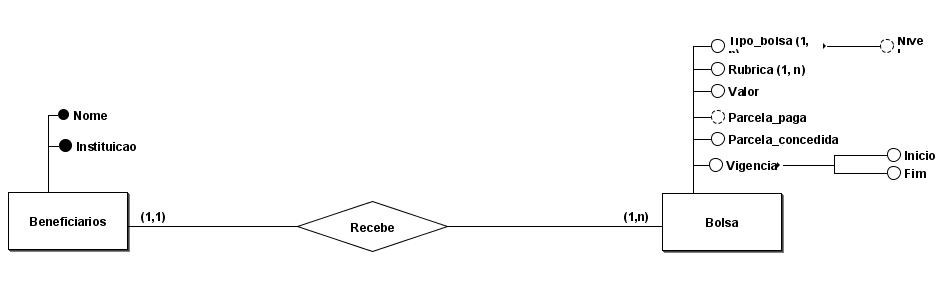

2. Modelo lógico

O modelo lígico foi obtido com base no esquema conceitual formulado anteriormente com a definição dos tipos de dados a serem inseridos no BD e as definições de chaves primarias e estrangeiras para cada tabela.

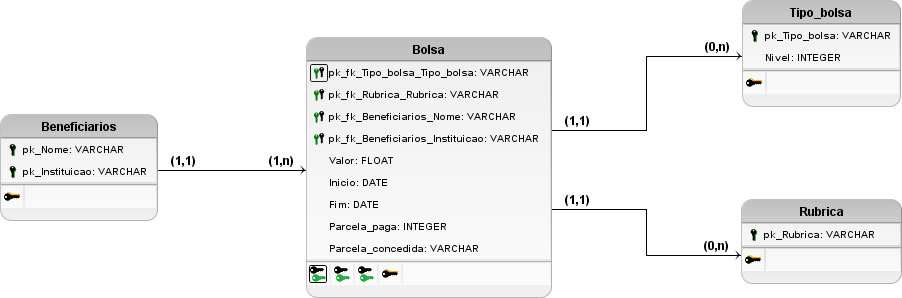

3. Modelo Físico (Utilizando Databricks versão Community)

O modelo físico foi feito baseado no modelo lógico anterior dentro do databricks versão community, portanto com um grande número de limitações, por exemplo, a não definição de PKs, FKs ou qualquer constraint. Também foi levada em conta a correspondência dos tipos de dados como mudança de "varchar" para "string".

In [ ]:
df.createOrReplaceTempView("Bolsas")

#Beneficiarios
spark.sql("CREATE DATABASE IF NOT EXISTS Banco")
spark.sql("CREATE OR REPLACE TABLE Banco.Beneficiarios (nome String, instituicao String)")
spark.sql("DELETE FROM Banco.Beneficiarios")
spark.sql("INSERT INTO Banco.Beneficiarios SELECT distinct BENEFICIARIO, INSTITUICAO from Bolsas ORDER BY BENEFICIARIO, INSTITUICAO")
display(spark.sql("SELECT * FROM Banco.Beneficiarios ORDER BY nome, instituicao"))

#Tipo_Bolsa
spark.sql("CREATE OR REPLACE TABLE Banco.Tipo_Bolsa (tipo String, nivel integer)")
spark.sql("DELETE FROM Banco.Tipo_Bolsa")
spark.sql("INSERT INTO Banco.Tipo_Bolsa SELECT distinct TIPO_DE_BOLSA, NIVEL_BOLSA from Bolsas ORDER BY TIPO_DE_BOLSA")
display(spark.sql("SELECT * FROM Banco.Tipo_Bolsa ORDER BY tipo"))

#Rubrica
spark.sql("CREATE OR REPLACE TABLE Banco.Rubrica (rubrica String)")
spark.sql("DELETE FROM Banco.Rubrica")
spark.sql("INSERT INTO Banco.Rubrica SELECT distinct RUBRICA from Bolsas ORDER BY RUBRICA")
display(spark.sql("SELECT * FROM Banco.Rubrica ORDER BY rubrica"))

#Bolsa
spark.sql("CREATE OR REPLACE TABLE Banco.Bolsa (beneficiario_nome String, beneficiario_instituicao String, tipo_bolsa String, rubrica String, valor Decimal(15,2), vigencia_inicio Date, vigencia_fim Date, parcela_paga Integer, parcela_concedida String)")
spark.sql("DELETE FROM Banco.Bolsa")
spark.sql("INSERT INTO Banco.Bolsa SELECT BENEFICIARIO, INSTITUICAO, TIPO_DE_BOLSA, RUBRICA, PAGAMENTO_EM_06_2024, VIGENCIA_INICIO, VIGENCIA_FIM, PARCELA_PAGA_EM_06_2024, TOTAL_DE_PARCELAS_CONCEDIDAS_NIVEL from Bolsas ORDER BY BENEFICIARIO")
display(spark.sql("SELECT * FROM Banco.Bolsa ORDER BY beneficiario_nome"))


#Autoavaliação

A ideia do objetivo do MVP, surgiu durante uma navegação pelo site da FAPESP, onde surgiu uma curiosidade sobre a disponibilidade dos dados de pagamentos de bolsas e auxílios, visto que se trata de uma grande agência de fomento à pesquisa no estado de São Paulo. Então surgiram as perguntas que foram relacionadas neste trabalho.

Com as perguntas formuladas fui atrás da informação dos pagamentos das bolsas que são disponibilizadas no portal da transparência da agência. O arquivo com esses dados mais recente (06/2024) foi então baixado e o trabalho teve início. Houve certa dificuldade para fazer o upload dos dados no DBFS do Databricks, mas através de consultas na internet consegui fazer o upload corretamente e em sequência a carga dos dados no notebook criado para a realização das análises.

Com os dados carregados foram percebidos alguns problemas de formatação da tabela, tipos de dados etc. Todos esses problemas tomaram algum tempo para a resolução por conta da falta de prática e familiaridade com a plataforma e a linguagem utilizada.

Após as devidas correções deu-se início a etapa da análise onde foram utilizados os conceitos de SQL apresentados durante a sprint. Todas as perguntas puderam ser respondidas com a correta formulação das pesquisas considerando os filtros e modos de apresentação dos resultados.

Foi feito uma modelagem hipotética para um possível banco de dados para que se pudesse inserir e agilizar pesquisas em trabalhos futuros, essa etapa não pode ser finalizada completamente devido às limitações da plataforma Databricks community, porém deu pra ter uma boa ideia da prática dessas etapas de todo o processo de Engenharia de Dados. Muito aprendizado foi adiquirido durante a realização deste trabalho.

Considerando tudo realizado até então neste trabalho, considero a availiação bastante positiva e pretendo continuar trabalhando para finalizar as etapas utilizando diferentes plataformas para a aquisição de prática.

